In [125]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#import xgboost as xgb

from IPython.display import display
from pandas import DataFrame, Series

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostRegressor
from sklearn.naive_bayes import GaussianNB

useYearDummies = False
useMonthDummies = False
useDayDummies = True
useCertainMonthData = True

In [147]:
rossmann_df  = pd.read_csv("input/train.csv")
store_df     = pd.read_csv("input/store.csv")
test_df      = pd.read_csv("input/test.csv")

store_df = store_df.drop('StoreType',1).join(pd.get_dummies(store_df['StoreType'], prefix='StoreType'))  
store_df = store_df.drop('Assortment',1).join(pd.get_dummies(store_df['Assortment'], prefix='Assortment'))  

store_df = store_df.drop('CompetitionDistance',1).join(np.log(store_df['CompetitionDistance']))  

def myPinterval(x):
    if x=='Feb,May,Aug,Nov':  return([0,1,0,0,1,0,0,1,0,0,1,0])
    elif x=='Jan,Apr,Jul,Oct':  return([1,0,0,1,0,0,1,0,0,1,0,0])
    elif x== 'Mar,Jun,Sept,Dec': return([0,0,1,0,0,1,0,0,1,0,0,1])
    else: return(np.repeat(0,12).tolist())

proInt = store_df.PromoInterval.apply(myPinterval).tolist()
proInt = pd.DataFrame(proInt, columns = ['ProInt'+ str(i) for i in range(1,13)])
store_df = store_df.drop('PromoInterval',1).join(proInt)

store_df.drop(["CompetitionOpenSinceMonth", "CompetitionOpenSinceYear",
              "Promo2SinceWeek", "Promo2SinceYear"], axis=1, inplace=True) 

display(store_df.head())

rossmann_df= pd.merge(rossmann_df, store_df.fillna(0), on="Store") 
test_df= pd.merge(test_df, store_df.fillna(store_df["CompetitionDistance"].median()), on="Store") 

display(rossmann_df.head())

# Map string features to integers
# This map function is very convienient
rossmann_df["StateHoliday"] = rossmann_df["StateHoliday"].map({0: 0, "0": 0, "a": 1, "b": 2, "c": 3})
test_df["StateHoliday"]     = test_df["StateHoliday"].map({0: 0, "0": 0, "a": 1, "b": 2, "c": 3})

# Then convert them to dummies
rossmann_df = rossmann_df.drop('StateHoliday',1).join(pd.get_dummies(rossmann_df['StateHoliday'], prefix='StateHoliday'))
test_df = test_df.drop('StateHoliday',1).join(pd.get_dummies(test_df['StateHoliday'], prefix='StateHoliday'))
test_df["StateHoliday_2"] = 0
test_df["StateHoliday_3"] = 0

# Create Year and Month columns
rossmann_df['Year']  = rossmann_df['Date'].apply(lambda x: int(str(x)[:4]))
rossmann_df['Month'] = rossmann_df['Date'].apply(lambda x: int(str(x)[5:7]))

test_df['Year']  = test_df['Date'].apply(lambda x: int(str(x)[:4]))
test_df['Month'] = test_df['Date'].apply(lambda x: int(str(x)[5:7]))

# Assign Date column to Date(Year-Month) instead of (Year-Month-Day)
# this column will be useful in analysis and visualization
rossmann_df.rename(columns={"Date":"Time"}, inplace=True)
test_df.rename(columns={"Date":"Time"}, inplace=True)
rossmann_df['Date'] = rossmann_df['Time'].apply(lambda x: (str(x)[:7]))
test_df['Date']     = test_df['Time'].apply(lambda x: (str(x)[:7]))

# Notice that test_df has only year=2015, and months 8 & 9

#rossmann_df = rossmann_df.loc[rossmann_df["Month"].isin([7,8,9])]

# drop Year and Month
# rossmann_df.drop(["Year", "Month"], axis=1, inplace=True)
# test_df.drop(["Year", "Month"], axis=1, inplace=True)

if useMonthDummies:
    rossmann_df = rossmann_df.join(pd.get_dummies(rossmann_df['Month'], prefix='Month'))
    
if useYearDummies:
    rossmann_df = rossmann_df.join(pd.get_dummies(rossmann_df['Year'], prefix='Year'))

if useDayDummies:
    # Create dummy varibales for DayOfWeek
    # Why not directly use the value? I think the point is that DayOfWeek is a categorical value.
    # The number itself has no meaning. That's why dummy is better than the value.
    day_dummies_rossmann  = pd.get_dummies(rossmann_df['DayOfWeek'], prefix='Day')
    day_dummies_test  = pd.get_dummies(test_df['DayOfWeek'],prefix='Day')


    # Since some stores open on Sunday, I think we should not exclude this dummy.
    # day_dummies_rossmann.drop(['Day_7'], axis=1, inplace=True)
    # day_dummies_test.drop(['Day_7'], axis=1, inplace=True)

    rossmann_df = rossmann_df.join(day_dummies_rossmann)
    test_df     = test_df.join(day_dummies_test)

    rossmann_df.drop(['DayOfWeek'], axis=1,inplace=True)
    test_df.drop(['DayOfWeek'], axis=1,inplace=True)

# remove all rows(store,date) that were closed
rossmann_df = rossmann_df[rossmann_df["Open"] != 0]

# save ids of closed stores, because we will assign their sales value to 0 later(see below)
closed_store_ids = test_df["Id"][test_df["Open"] == 0].values

# remove all rows(store,date) that were closed
test_df = test_df[test_df["Open"] != 0]

# drop unnecessary columns, these columns won't be useful in prediction
rossmann_df.drop(["Open", "Customers", "Date"], axis=1, inplace=True)
test_df.drop(['Open', 'Date'], axis=1,inplace=True)

/Applications/anaconda/envs/3.4/lib/python3.4/site-packages/IPython/core/interactiveshell.py:2902: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Store,Promo2,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c,CompetitionDistance,...,ProInt3,ProInt4,ProInt5,ProInt6,ProInt7,ProInt8,ProInt9,ProInt10,ProInt11,ProInt12
0,1,0,0,0,1,0,1,0,0,7.146772,...,0,0,0,0,0,0,0,0,0,0
1,2,1,1,0,0,0,1,0,0,6.345636,...,0,1,0,0,1,0,0,1,0,0
2,3,1,1,0,0,0,1,0,0,9.556055,...,0,1,0,0,1,0,0,1,0,0
3,4,0,0,0,1,0,0,0,1,6.429719,...,0,0,0,0,0,0,0,0,0,0
4,5,0,1,0,0,0,1,0,0,10.305948,...,0,0,0,0,0,0,0,0,0,0


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Promo2,...,ProInt3,ProInt4,ProInt5,ProInt6,ProInt7,ProInt8,ProInt9,ProInt10,ProInt11,ProInt12
0,1,5,2015-07-31,5263,555,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,1,4,2015-07-30,5020,546,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,1,3,2015-07-29,4782,523,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,1,2,2015-07-28,5011,560,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,1,1,2015-07-27,6102,612,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0


### Preparing Data for ML

In [148]:

# Since the data are time series, we do not start with the cross-validation.
# Rather, we use the most recent 6 week data as the validation set, and the rest as the training set.
# TODO: I think there will be better methods to handle time series data?

train_df = rossmann_df.loc[~rossmann_df['Time'].isin(
        pd.date_range('2015-06-20', periods=6 * 7).astype(str))]


if useCertainMonthData:
    # We want the algorithm to consider month. One method is to use only months for the validation set.
    # But this also significantly reduces the sample size.
    train_df = train_df.loc[rossmann_df["Month"].isin([6, 7])] #.loc[rossmann_df["Year"].isin([2015])]

validation_df = rossmann_df.loc[rossmann_df['Time'].isin(
                            pd.date_range('2015-06-20', periods=6 * 7).astype(str))]

display(train_df.head())
display(validation_df.head())
print(train_df.shape)
print(validation_df.shape)

train_dict = dict(list(train_df.groupby('Store')))
validation_dict = dict(list(validation_df.groupby('Store')))

test_dic = dict(list(test_df.groupby('Store')))

,Store,Time,Sales,Promo,SchoolHoliday,Promo2,StoreType_a,StoreType_b,StoreType_c,StoreType_d,...,StateHoliday_3,Year,Month,Day_1,Day_2,Day_3,Day_4,Day_5,Day_6,Day_7
42,1,2015-06-19,4202,1,0,0,0,0,1,0,...,0,2015,6,0,0,0,0,1,0,0
43,1,2015-06-18,4645,1,0,0,0,0,1,0,...,0,2015,6,0,0,0,1,0,0,0
44,1,2015-06-17,4000,1,0,0,0,0,1,0,...,0,2015,6,0,0,1,0,0,0,0
45,1,2015-06-16,4852,1,0,0,0,0,1,0,...,0,2015,6,0,1,0,0,0,0,0
46,1,2015-06-15,5518,1,0,0,0,0,1,0,...,0,2015,6,1,0,0,0,0,0,0


,Store,Time,Sales,Promo,SchoolHoliday,Promo2,StoreType_a,StoreType_b,StoreType_c,StoreType_d,...,StateHoliday_3,Year,Month,Day_1,Day_2,Day_3,Day_4,Day_5,Day_6,Day_7
0,1,2015-07-31,5263,1,1,0,0,0,1,0,...,0,2015,7,0,0,0,0,1,0,0
1,1,2015-07-30,5020,1,1,0,0,0,1,0,...,0,2015,7,0,0,0,1,0,0,0
2,1,2015-07-29,4782,1,1,0,0,0,1,0,...,0,2015,7,0,0,1,0,0,0,0
3,1,2015-07-28,5011,1,1,0,0,0,1,0,...,0,2015,7,0,1,0,0,0,0,0
4,1,2015-07-27,6102,1,1,0,0,0,1,0,...,0,2015,7,1,0,0,0,0,0,0


(127881, 39)
(40282, 39)


### Prediction - Helpers

In [45]:
def rmspe(yhat, y):
    # Learn how to efficiently do ndarray calculation, see the original in 
    # https://www.kaggle.com/paso84/rossmann-store-sales/xgboost-in-python-with-rmspe/code
    return np.sqrt(np.mean(((y - yhat) / y)**2))

methods = ["Random Forest", "Linear Regression", "Logistic Regression", "AdaBoost"]

def genReg(method):
    reg = None
    if method == "Random Forest":
        reg = RandomForestRegressor(n_estimators = 100)

    elif method == "Linear Regression":
        reg = LinearRegression()

    # Slow and poor
    elif method == "Logistic Regression":
        reg = LogisticRegression()

    # Slightly worse than RF
    elif method == "AdaBoost":
        reg = AdaBoostRegressor(n_estimators = 100)
        
    return reg

### Prediction - Individual Store

In [151]:
# Evaluation

# Use cross-validation to evaluate different methods. Basically, for each machine learning configuration,
# we want to have a score.

# A machine learning config = method + data


useAdjust = False

# Other methods: ["Logistic Regression", "Linear Regression"]
# Logistic Regression is really slow and inaccurate.
# Linear Regression is slightly worse than Random Forest

adjust = {192:3000, 274:1500, 1086: -1500, 676:1500, 713:-2000, 722:-2000, 815:-2000, 948:1500}

# for method in methods:
    
def predict(method, allMethod = False):
    print("Working on " + method)
    
    Y = np.empty([0])
    Y_hat = np.empty([0])
    store_ids = []
    times = []
    
    printImportance = True

    for i in test_dic:

        X_train = train_dict[i].drop(["Sales", "Store", "Time", "Year", "Month"], axis=1)
        Y_train = train_dict[i]["Sales"]

        X_validation  = validation_dict[i].copy()
        X_validation.drop(["Sales", "Store", "Time", "Year", "Month"], axis=1,inplace=True)
        Y_validation = validation_dict[i]["Sales"]
        _times = validation_dict[i]["Time"]
        
        if allMethod == False:

            reg = genReg(method)
            reg.fit(X_train, Y_train)
            Y_pred = reg.predict(X_validation)    
            
            if printImportance and method == "Random Forest":
                for j in range(0, len(reg.feature_importances_)):
                    print(" %s: %f " % (X_train.columns[j], reg.feature_importances_[j]))
                printImportance = False
        else:
            # TODO: Try different methds for each store
            # for method in methods:
            assert False
                
            
        Y = np.append(Y, Y_validation)
        #display(Y_pred[0:10])
        #display(Y_pred + 100)[0:10]
        
        if useAdjust and i in adjust:
            Y_pred = Y_pred + adjust[i]
        
        Y_hat = np.append(Y_hat, Y_pred)
        store_ids += [i] * len(Y_pred)
        
        times += list(_times)
            
    print(np.shape(Y_hat))
    print(rmspe(Y_hat, Y))

    diff = pd.Series(Y_hat - Y)
    diff_df = pd.DataFrame({"Diff":diff, "Store":store_ids, "Time":times})
    
    return diff_df

_diff_df = predict("Linear Regression")

   

Working on Linear Regression
(30960,)
0.153924354473


### Prediction - Single Model

The result is better than individual, if we include store as a feature!

One issue is, shuold we turn the store ID to dummy? Seems that no need. See the discussion here:
http://stats.stackexchange.com/questions/95212/improve-classification-with-many-categorical-variables

TODO: Should we get rid of day-dummies as well?

In [146]:
def predict(method, allMethod = False):
    
    X_train = train_df.drop(["Sales", "Time", "Year", "Month"],axis=1)
    Y_train = train_df["Sales"]    

    X_validation  = validation_df.copy()
    X_validation.drop(["Sales", "Time", "Year", "Month"], axis=1,inplace=True)
    Y_validation = validation_df["Sales"]
    _times = validation_df["Time"]

    reg = genReg(method)
    reg.fit(X_train, Y_train)
    Y_pred = reg.predict(X_validation)   
    
    print(np.shape(Y_pred))
    print(rmspe(Y_pred, Y_validation))
    
    for j in range(0, len(reg.feature_importances_)):
        print(" %s: %f " % (X_train.columns[j], reg.feature_importances_[j]))


predict("Random Forest")

(40282,)
0.149140039183
 Store: 0.281493 
 Promo: 0.183185 
 SchoolHoliday: 0.012507 
 Promo2: 0.018558 
 StoreType_a: 0.019545 
 StoreType_b: 0.027919 
 StoreType_c: 0.013979 
 StoreType_d: 0.014595 
 Assortment_a: 0.010432 
 Assortment_b: 0.001019 
 Assortment_c: 0.013100 
 CompetitionDistance: 0.289300 
 ProInt1: 0.002431 
 ProInt2: 0.001569 
 ProInt3: 0.003611 
 ProInt4: 0.002406 
 ProInt5: 0.001753 
 ProInt6: 0.004046 
 ProInt7: 0.002362 
 ProInt8: 0.001654 
 ProInt9: 0.003386 
 ProInt10: 0.002502 
 ProInt11: 0.001713 
 ProInt12: 0.003377 
 StateHoliday_0: 0.000704 
 StateHoliday_1: 0.000696 
 StateHoliday_2: 0.000000 
 StateHoliday_3: 0.000000 
 Day_1: 0.042461 
 Day_2: 0.006024 
 Day_3: 0.003283 
 Day_4: 0.002923 
 Day_5: 0.005406 
 Day_6: 0.016342 
 Day_7: 0.005721 


### Error Analysis

TODO: Now, we want to see the error of each instance. We hope to answer the following questions:
1. Is there a systematic bias in prediction?
2. What about the variance?
3. How can we improve?


For RMSPE, is it sensitive to outliers? If so, we can spend more time to correct the outliers.

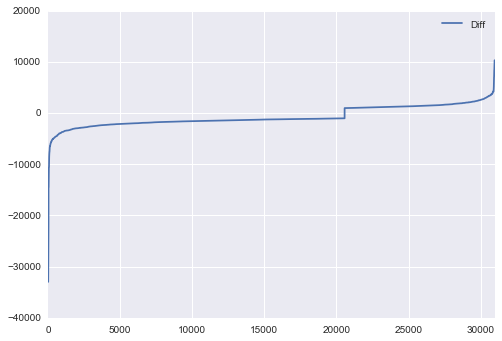

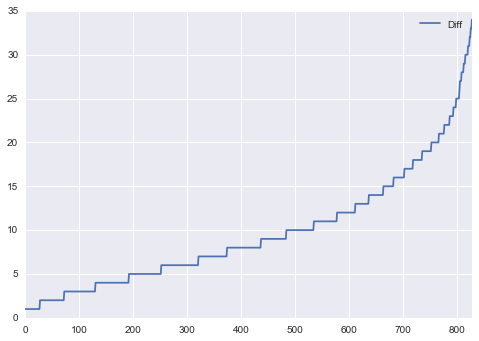

Int64Index([676, 713, 815, 722, 948], dtype='int64', name='Store')


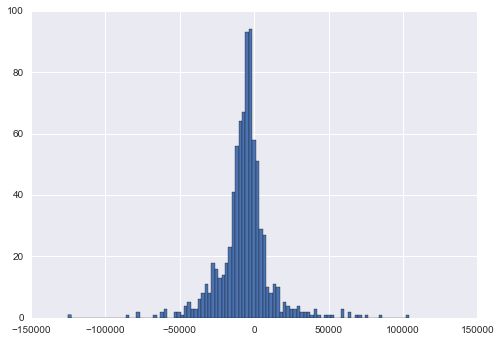

count       829.000000
mean      -6360.887034
std       18213.142169
min     -125232.141854
25%      -12662.796062
50%       -5377.427380
75%          55.341113
max      104227.100291
Name: Diff, dtype: float64
Store
676   -1752.812339
713    2274.185285
722    2251.026336
815    2050.917534
948   -1577.572524
Name: Diff, dtype: float64


In [56]:

# Focus on large prediction errors.
diff_df = _diff_df.loc[abs(_diff_df["Diff"]) > 1000]

# Show error distribution

diff_df.sort_values(by = ["Diff"]).plot(x = diff_df.index, y = "Diff")

# One effect of this line is to generate a unique figure
plt.show()

# TODO: We can see that most predictions are pretty good. But there are some extremely large errors.
# Can we find out them?

# We want to see the count of large errors for each store
# From the result, we can see that most stores have 36 large errors!
# I feel there is a strong bias.
diff_df.groupby("Store").count().sort_values(by = ["Diff"]).plot(x = np.arange(0, len(diff_df.groupby("Store"))), y = "Diff")

# This makes sure that the figure is shown in this position.
plt.show()

# Stores with most large errors

topErrorStores = diff_df.groupby("Store").count().sort_values(by = ["Diff"], ascending = False).index[0:5]

print(topErrorStores)

# We now get the sum of errors for each store. We want to see if there is a systematic prediction bias.
# From the results, seems that there is a slight shifts to the left.
store_sum = diff_df.groupby("Store")['Diff'].sum()
store_sum.hist(bins = 100)

# This makes sure that the figure is shown in this position.
plt.show()

print(store_sum.describe())


# We look at the errors of some stores
# We can see that store 7 is always negative (underestimated)
# In the exploration note, it seems that store 7 will have 
#display(diff_df.sort_values(by = ["Store"]).loc[diff_df["Store"].isin([676])])

print(diff_df.loc[diff_df["Store"].isin(topErrorStores)].groupby(["Store"])["Diff"].mean())

## Submission

### Data Preparation

In [142]:

# TODO: We can only use the first half of Sept.
rossmann_df = rossmann_df.loc[rossmann_df["Month"].isin([7,8,9])]
submission   = Series()
scores       = []

### Prediction - Individual Store Models - Submission

In [12]:
# Loop through each store, 
# train the model using the data of current store, and predict it's sales values.

rossmann_dic = dict(list(rossmann_df.groupby('Store')))
test_dic     = dict(list(test_df.groupby('Store')))

method = "Random Forest"

adjust = {192:3000, 274:1500, 1086:-1500, 676:1500, 713:-2000, 722:-2000, 815:-2000, 948:1500}


for i in test_dic:
    
    # current store
    store = rossmann_dic[i]
    
    # define training and testing sets
    X_train = store.drop(["Sales","Store", "Time"],axis=1)
    Y_train = store["Sales"]
    X_test  = test_dic[i].copy()
    
    store_ids = X_test["Id"]
    X_test.drop(["Id","Store", "Time"], axis=1,inplace=True)
    
    if method == "Linear Regression":
        lreg = LinearRegression()
        lreg.fit(X_train, Y_train)
        Y_pred = lreg.predict(X_test)
        scores.append(lreg.score(X_train, Y_train))
    elif method == "Xgboost":
        params = {"objective": "reg:linear",  "max_depth": 10}
        T_train_xgb = xgb.DMatrix(X_train, Y_train)
        X_test_xgb  = xgb.DMatrix(X_test)
        gbm = xgb.train(params, T_train_xgb, 100)
        Y_pred = gbm.predict(X_test_xgb)
    elif method == "Random Forest":
        rf = RandomForestRegressor(n_estimators = 100)
        rf.fit(X_train, Y_train)
        Y_pred = rf.predict(X_test)
        scores.append(rf.score(X_train, Y_train))
        
    if i in adjust:
        Y_pred += adjust[i]
    
    # append predicted values of current store to submission
    submission = submission.append(Series(Y_pred, index=store_ids))

# append rows(store,date) that were closed, and assign their sales value to 0
submission = submission.append(Series(0, index=closed_store_ids))

# save to csv file
submission = pd.DataFrame({ "Id": submission.index, "Sales": submission.values})
submission.to_csv('rossmann.csv', index=False)

### Prediction - Single Model - Submission

In [121]:
display(test_df.drop(["Id", "Time", "Year", "Month"], axis=1).head())
display(rossmann_df.drop(["Sales", "Time", "Year", "Month"],axis=1).head())

,Store,DayOfWeek,Promo,SchoolHoliday,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c,CompetitionDistance,StateHoliday_0,StateHoliday_1
0,1,4,1,0,0,0,1,0,1,0,0,7.146772,1,0
1,1,3,1,0,0,0,1,0,1,0,0,7.146772,1,0
2,1,2,1,0,0,0,1,0,1,0,0,7.146772,1,0
3,1,1,1,0,0,0,1,0,1,0,0,7.146772,1,0
5,1,6,0,0,0,0,1,0,1,0,0,7.146772,1,0


,Store,DayOfWeek,Promo,SchoolHoliday,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c,CompetitionDistance,StateHoliday_0,StateHoliday_1,StateHoliday_2,StateHoliday_3
0,1,5,1,1,0,0,1,0,1,0,0,7.146772,1,0,0,0
1,1,4,1,1,0,0,1,0,1,0,0,7.146772,1,0,0,0
2,1,3,1,1,0,0,1,0,1,0,0,7.146772,1,0,0,0
3,1,2,1,1,0,0,1,0,1,0,0,7.146772,1,0,0,0
4,1,1,1,1,0,0,1,0,1,0,0,7.146772,1,0,0,0


In [143]:


method = "Random Forest"

X_train = rossmann_df.drop(["Sales", "Time", "Year", "Month"],axis=1)
Y_train = rossmann_df["Sales"]

X_test  = test_df.copy()
X_test.drop(["Id", "Time", "Year", "Month"], axis=1,inplace=True)

store_ids = test_df["Id"]

reg = genReg(method)
reg.fit(X_train, Y_train)
Y_pred = reg.predict(X_test)   

submission = submission.append(Series(Y_pred, index=store_ids))
submission = submission.append(Series(0, index=closed_store_ids))

submission = pd.DataFrame({ "Id": submission.index, "Sales": submission.values})
submission.to_csv('rossmann.csv', index=False)

for j in range(0, len(reg.feature_importances_)):
    print(" %s: %f " % (X_train.columns[j], reg.feature_importances_[j]))



 Store: 0.282879 
 Promo: 0.178567 
 SchoolHoliday: 0.008881 
 Promo2: 0.021868 
 StoreType_a: 0.019240 
 StoreType_b: 0.028149 
 StoreType_c: 0.013778 
 StoreType_d: 0.015107 
 Assortment_a: 0.010760 
 Assortment_b: 0.001208 
 Assortment_c: 0.015337 
 CompetitionDistance: 0.301042 
 ProInt1: 0.002419 
 ProInt2: 0.001739 
 ProInt3: 0.002628 
 ProInt4: 0.002235 
 ProInt5: 0.001581 
 ProInt6: 0.003920 
 ProInt7: 0.002248 
 ProInt8: 0.001427 
 ProInt9: 0.003543 
 ProInt10: 0.002384 
 ProInt11: 0.001631 
 ProInt12: 0.003661 
 StateHoliday_0: 0.000003 
 StateHoliday_1: 0.000003 
 StateHoliday_2: 0.000000 
 StateHoliday_3: 0.000000 
 Day_1: 0.036162 
 Day_2: 0.006597 
 Day_3: 0.002996 
 Day_4: 0.002462 
 Day_5: 0.004097 
 Day_6: 0.014948 
 Day_7: 0.006500 
